# Building makemore: activations, gradients, BatchNorm

https://www.youtube.com/watch?v=P6sfmUTpUmc

This time, develop intuitive understanding of forward activations, backward gradients to help understand more complex systems like recurrent neural networks, which are harder to optimize.

# Setup & data

We're using the same libraries and data as in the previous makemore lectures.

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [10]:
# Import data
words = open('makemore/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [11]:
# Build vocabulary - same approach as last lecture, identical code
# Put special . as 0 element, and shift the alphabet over by 1
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
print(vocab_size)

27


In [12]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

# Creating the training, validation, and test sets
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


The below code is a cleaned up version of the MLP model from lecture 3, with former "magic numbers" parametrized at the top.

In [13]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


Rerunning the old model.

In [16]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.7667
  20000/ 200000: 2.6773
  30000/ 200000: 2.7836
  40000/ 200000: 2.0416
  50000/ 200000: 2.6894
  60000/ 200000: 2.2941
  70000/ 200000: 2.1137
  80000/ 200000: 2.3393
  90000/ 200000: 2.1892
 100000/ 200000: 2.0250
 110000/ 200000: 2.3710
 120000/ 200000: 2.0257
 130000/ 200000: 2.3571
 140000/ 200000: 2.2188
 150000/ 200000: 2.1529
 160000/ 200000: 2.1815
 170000/ 200000: 1.7772
 180000/ 200000: 2.0281
 190000/ 200000: 1.7446


Took about 1:20 on my machine.

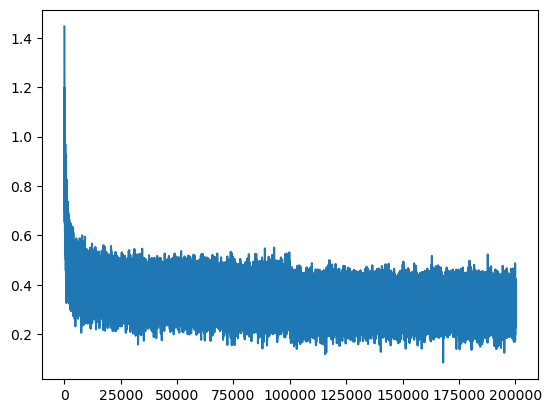

In [17]:
plt.plot(lossi)

And sampling from the MLP model:

In [18]:
@torch.no_grad() # this decorator disables gradient tracking
# no_grad Basically tells Torch the backward pass won't be performed so it doesn't need to keep track of the network graph
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1256096363067627
val 2.169816732406616


In [19]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mora.
mayah.
see.
mel.
ryllo.
emmadiengrael.
adelyn.
elin.
shy.
jenreigh.
estana.
selyn.
malkia.
noshubergihamies.
kendreelynn.
nocoorius.
macder.
yaralyek.
yuma.
mysanyah.


# Optimizing the MLP model initialization

Initialization can be done much better. First pass is way too high, on iteration 0 loss is 27. Can set up the parameters more cleverly; theoretically if letters are draws from a uniform distribution the expected loss should be lower. Network is "very confidently wrong" and thus records high loss.

In [21]:
# Expected initial loss
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [22]:
# 4-dimensional example of the issue
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim = 0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

In [23]:
# If probability is randomly assigned to the correct index we'll randomly have low loss.
logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
probs = torch.softmax(logits, dim = 0)
loss = -probs[2].log()
probs, loss

(tensor([0.0066, 0.0066, 0.9802, 0.0066]), tensor(0.0200))

In [25]:
# If probability is randomly assigned to the wrong indices (more likely) we'll randomly have high loss.
logits = torch.tensor([1.0, 5.0, 0.0, -1.0])
probs = torch.softmax(logits, dim = 0)
loss = -probs[2].log()
probs, loss

(tensor([0.0178, 0.9732, 0.0066, 0.0024]), tensor(5.0272))

In [26]:
logits = torch.randn(4)
probs = torch.softmax(logits, dim = 0)
loss = -probs[2].log()
logits, probs, loss

(tensor([0.3845, 0.0741, 0.3884, 0.1530]), tensor(0.9457))

When initialized values are near 0, the loss is low. But when they're large, the average loss is very high.

In [27]:
# Multiply initial values by 10
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim = 0)
loss = -probs[2].log()
logits, probs, loss

(tensor([  5.5445, -13.8826, -19.3197, -11.9888]),
 tensor([1.0000e+00, 3.6552e-09, 1.5907e-11, 2.4287e-08]),
 tensor(24.8643))

Solution: shrink the initial values of the network to 0. Logits are defined as `h @ W2 + b2` so we can set b2 to 0 and W2 to a small number.

In [45]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

# Training

max_steps = 1
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/      1: 4.2326


Much better. But why not just set everything to 0 starting out? Usually safer using small numbers, not exactly 0, or things can go wrong. 0.01 should be fine; there is a bit of randomness that can be used for "symmetry breaking."

In [47]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

# Training

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8644
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


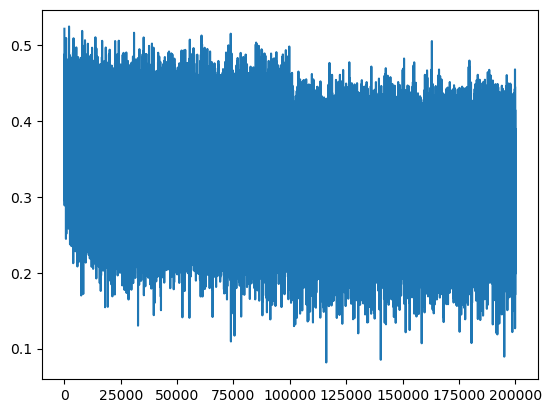

In [48]:
plt.plot(lossi)

No more "hockey stick" appearance with easy gains at the beginning because we're starting with more sensible parameters. We also end up with a better final model because the first cycles of the training loop aren't wasted getting down to ~3.3:

In [49]:
@torch.no_grad() # this decorator disables gradient tracking
# no_grad Basically tells Torch the backward pass won't be performed so it doesn't need to keep track of the network graph
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.069589138031006
val 2.1310744285583496


There's still a more subtle problem lurking with the initialization. Logits are ok but h is not; activation of the hidden states.

In [51]:
h.shape, h

(torch.Size([32, 200]),
 tensor([[ 0.7100, -0.7879, -0.7424,  ..., -1.0000,  1.0000,  1.0000],
         [-0.5615, -1.0000, -1.0000,  ..., -0.8078,  0.9971, -0.9209],
         [-1.0000,  0.9940, -1.0000,  ...,  0.3851, -0.9303,  0.3262],
         ...,
         [-0.9992, -1.0000, -0.9999,  ..., -0.4351, -0.8976, -0.3768],
         [ 0.9939,  0.8976,  1.0000,  ..., -0.9538, -1.0000,  0.9987],
         [-1.0000, -0.9995, -1.0000,  ..., -0.6407, -0.8208,  0.5101]],
        grad_fn=<TanhBackward0>))

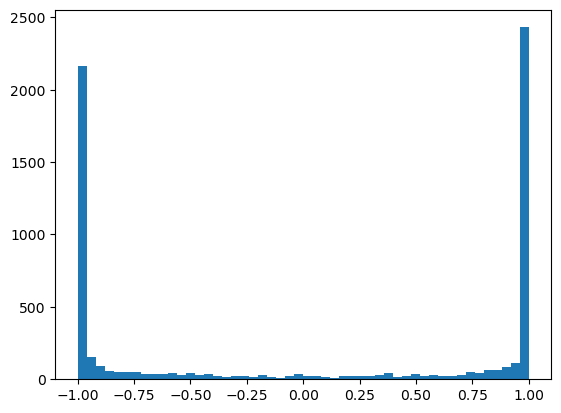

In [52]:
plt.hist(h.view(-1).tolist(), 50);

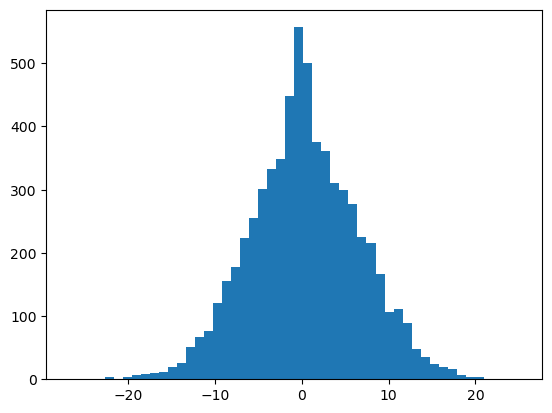

In [53]:
plt.hist(hpreact.view(-1).tolist(), 50);

Most values are -1 or 1 which is not desirable. Preactivations take a very broad range of values. During backpropagation due to the implementation of `tanh`, if t = -1 or 1 then self.grad will return 0:

In [ ]:
def _backward():
    self.grad += (1 - t**2) * out.grad

Gradients going through the network will get shrunk to 0 due to this problem.

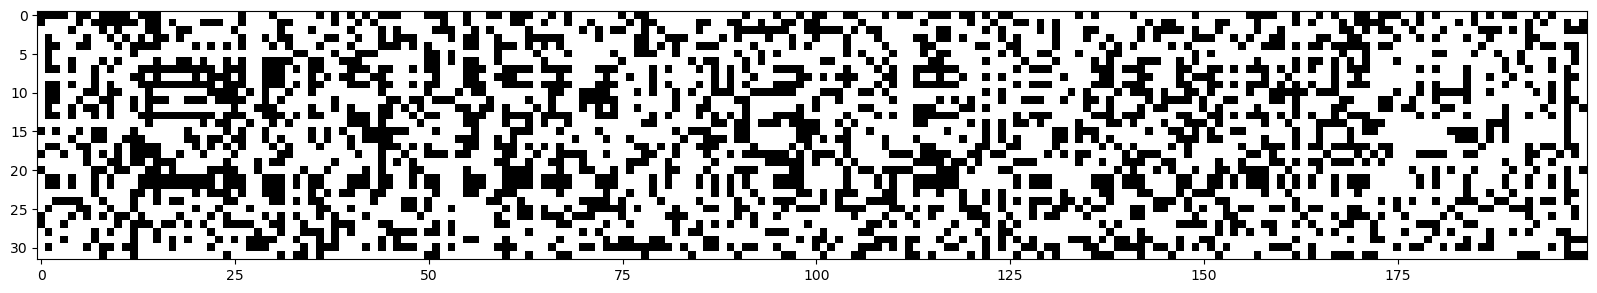

In [54]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation = 'nearest')

The white blocks are where the `tanh` function will squash the gradient. If an entire column is white it's a dead neuron - no example can activate it and it can never learn. Not the case with this specific example, but why take the risk?

A similar problem can occur with too high a learning rate; a neuron can get set to such a "dead" state where it won't learn anymore.

Solution: shrink the initial `hpreact` distribution.

In [55]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

# Training

max_steps = 1
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/      1: 3.3069


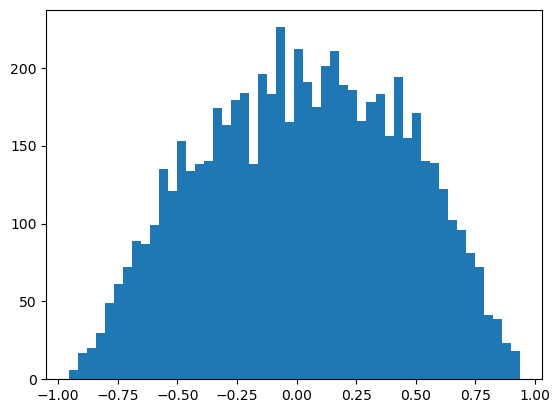

In [57]:
plt.hist(h.view(-1).tolist(), 50);

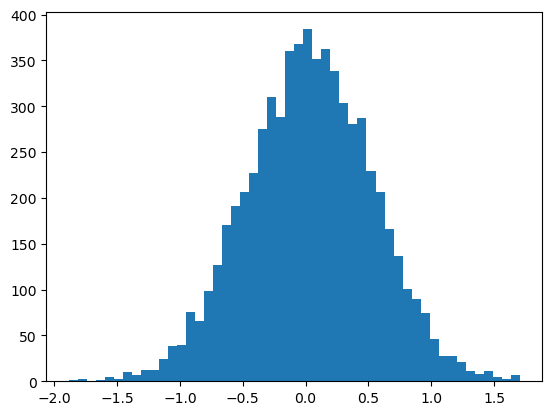

In [58]:
plt.hist(hpreact.view(-1).tolist(), 50);

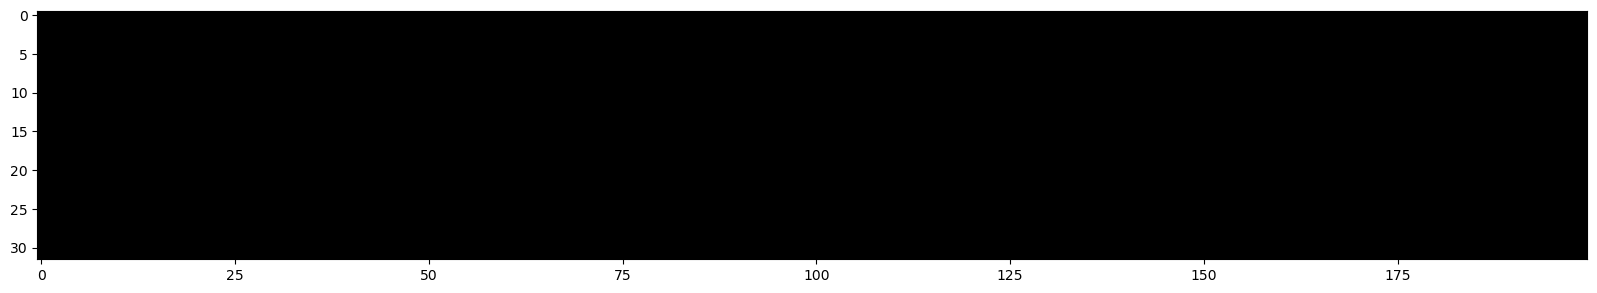

In [56]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation = 'nearest')

All black because no neurons were initialized to .99. Not necessarily bad to have a little noise, so W1 multiplier could be 0.2 instead of 0.1.

In [59]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

# Training

max_steps = 1
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/      1: 3.3135


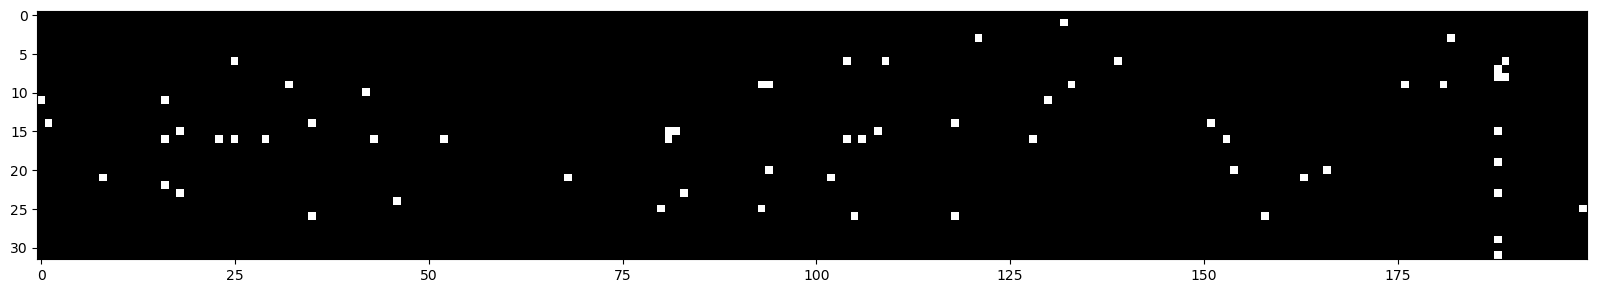

In [60]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation = 'nearest')

Training the model with the new initialization method.

In [61]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

# Training

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


In [62]:
@torch.no_grad() # this decorator disables gradient tracking
# no_grad Basically tells Torch the backward pass won't be performed so it doesn't need to keep track of the network graph
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0355966091156006
val 2.102677822113037


Best validation loss yet. Note that even the first model wasn't terrible, but bad initialization becomes an increasing problem with more complex, multilayered networks.

Why use the magic numbers above? Why not shrink the initial parameters by some other number? Recall initial distributions are $N(0,1)$ but after multiplying the standard deviation grows:

tensor(-0.0060) tensor(1.0082)
tensor(-0.0011) tensor(3.1832)


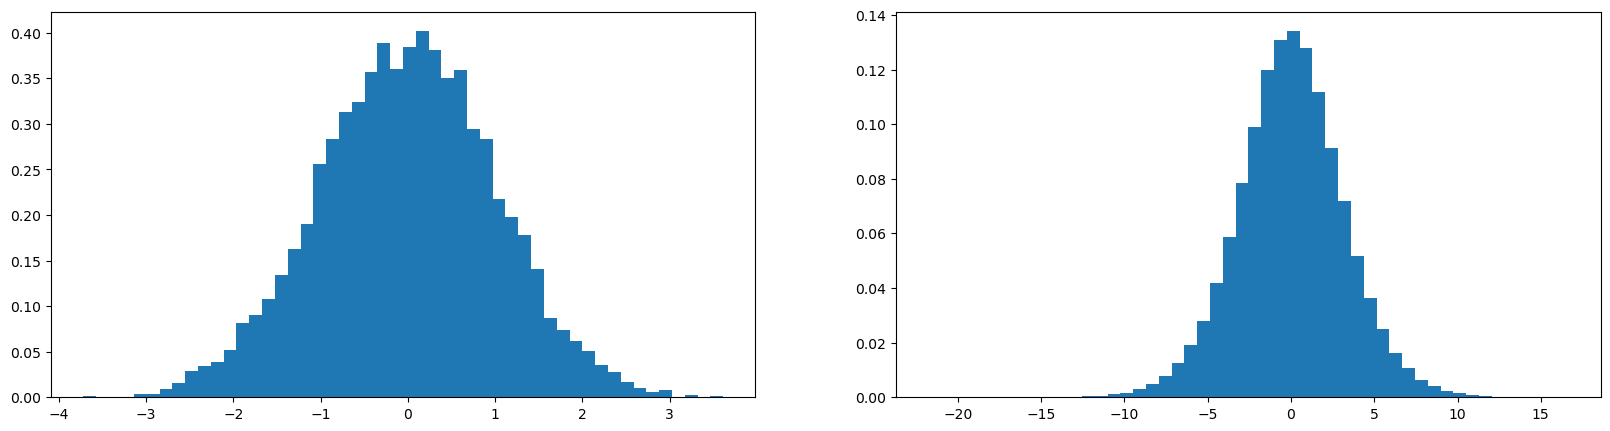

In [4]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

Goal is to scale down the standard deviation so it's 1. Want to divide by square root of inputs (10 here).

tensor(-0.0026) tensor(1.0093)
tensor(-0.0007) tensor(1.0100)


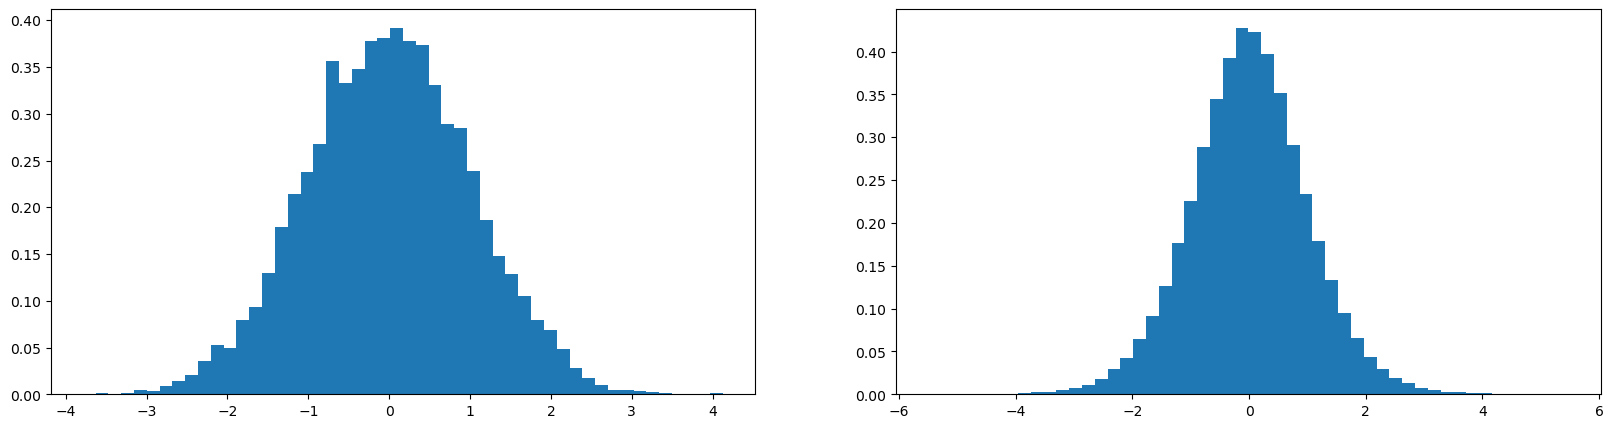

In [6]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

Relevant paper: "Delving Deep into Rectifiers" uses a similar approach. For parameter initialization, use a $\sqrt{\frac{2}{n_l}}$ forward pass initialization and the backward pass is also $N(0, 1)$ to some constant factor. Turns out in $tanh$ the gain is $\frac{5}{3}$.

Less important to initialize modern networks exactly right due to various innovations in training, including better optimizers. But every bit still helps.

In [27]:
print(n_embd)
print(block_size)
print(5/3 / (n_embd * block_size)**.5)

10
3
0.3042903097250923


Optimal initialization multiplies by .3, instead of .2 which we had before.

In [28]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / (n_embd * block_size)**0.5
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

# Training

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9752
 190000/ 200000: 1.8614


# Batch normalization

Example of a modern innovation that makes precise initialization less impactful for very deep neural networks. From this code:

In [ ]:
hpreact = embcat @ W1 + b1

Why not just initialize this to $N(0, 1)$ to begin with?

In [33]:
print(hpreact.shape)
print(hpreact.mean(0, keepdim=True).shape)
print(hpreact.std(0, keepdim=True).shape)

torch.Size([32, 200])
torch.Size([1, 200])
torch.Size([1, 200])


Normalize each element using the usual formula (z-score like). $z_i = \frac{x_i - \bar{x}}{\sigma}$

But it's desirable to not force $N(0, 1)$ every single time; add a scaling term and a bias term.

In [38]:
# New terms!
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / (n_embd * block_size)**0.5
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# Includes new terms
parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
  p.requires_grad = True

# Training

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  ## New term
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim = True)) / hpreact.std(0, keepdim = True) + bnbias
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


This runs much more slowly. Can be optimized by adding batch norm layers within the neural network, rather than running every single time.

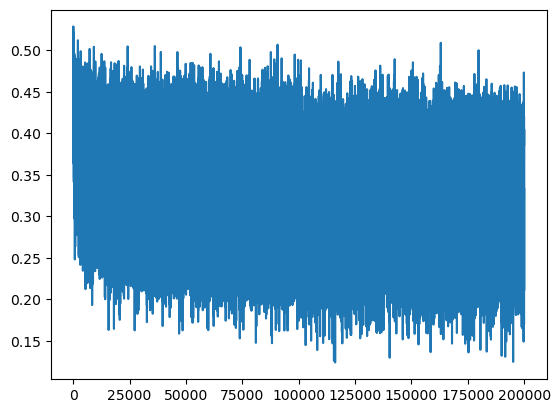

In [39]:
plt.plot(lossi)

In [43]:
@torch.no_grad() # this decorator disables gradient tracking
# no_grad Basically tells Torch the backward pass won't be performed so it doesn't need to keep track of the network graph
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  # New code with preactivation terms
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.157904624938965
val 2.1899030208587646


Comparable to previous loss; but we don't necessarily expect an improvement yet with a simple network (only 1 hidden layer).

Subtle issue: stability has a cost. Previously, 1 example fed into the logits, etc. When we were running batches for efficiency, the logits were still independent. But with batch normalization, elements in each batch of 32 are now dependent on one another in the forward/backward pass, due to calculating $\bar{x}$ and $\sigma$ for the sample. Imagine introducing a jitter to $h$ and $logits$ but it turns out this isn't an issue. Behaves like a regularization term, introducing bias to reduce variance.

Look at examples of weird outcomes of dependence. Start by computing bnmean and bnstd once for the entire training set, for efficiency.

In [41]:
with torch.no_grad():
    # pass the training ste through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

Then use these calibrated statistics rather than computing for the batch. This allows passing a single example, rather than batches, through the trained network.

In [44]:
@torch.no_grad() # this decorator disables gradient tracking
# no_grad Basically tells Torch the backward pass won't be performed so it doesn't need to keep track of the network graph
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  # New code with preactivation terms
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0668270587921143
val 2.1049270629882812


Batch norm also introduced idea of estimating running mean and std during training. Also want to get rid of all the + b1 terms, since the bias just gets subtracted out during normalization anyway.

In [54]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [55]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


Summary: BatchNorm controls neural network activations so you don't see extreme values. BatchNorm layers are generally used after multiplication layers (linear or convolutional) to rescale parameters to $N(0,1)$.

Internally it has parameters for gain and bias, plus tracks the running mean and standard deviation updating based on the batch means and standard deviations with some weighted average. The mean and standard deviation computations are used for inference and don't have to be used in backpropagation.